In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from uncertainties import unumpy as unp
import uncertainties
import seaborn as sb
import matplotlib.cm as cm
import scipy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.stats.mstats import gmean

1. Read the data

In [2]:
raw_data = pd.read_excel('data/RawData.xlsx')
#raw_data = raw_data[~raw_data.units.str('trap')]

2. Focus on the population data

In [3]:
pop_data = raw_data[raw_data.units == 'individuals/m^2']

3. Remove partial measurements

In [4]:
metadata = pd.read_csv('data/groups_per_reference.csv')
pop_data_with_meta = pop_data.merge(metadata,left_on='reference', right_on='Paper',how='left')

In [5]:
pop_data_with_meta.groupby('Standard groups')['site'].nunique()

Standard groups
Acari                9
Arthropods         173
Isoptera             1
Macroarthropods     33
Microarthropods      5
Mites                5
Some arthropods      4
Name: site, dtype: int64

In [6]:
raw_data_with_meta = raw_data.merge(metadata,left_on='reference', right_on='Paper',how='left')
raw_data_val = raw_data_with_meta[(raw_data_with_meta['Standard groups']!='Microarthropods') | ((raw_data_with_meta['Standard groups']=='Microarthropods') & (raw_data_with_meta['sub-class'].isin(['Acari','Collembola'])))]
raw_data_val = raw_data_val[~raw_data_val['Standard groups'].isna()]
raw_data_val.groupby(['aggregated environment']).site.nunique()

aggregated environment
above ground     34
plants           51
soil/litter     303
Name: site, dtype: int64

In [7]:
valid_data = pop_data_with_meta.copy()
valid_data = valid_data[(valid_data['Standard groups']!='Microarthropods') | ((valid_data['Standard groups']=='Microarthropods') & (valid_data['sub-class'].isin(['Acari','Collembola'])))]

4. Classify into groups using "aggregated taxon" and "aggregated environment"

In [8]:
valid_data.loc[valid_data['sub-class']=='Acari','aggregated taxon'] = 'Acari'
valid_data.loc[valid_data['sub-class']=='Collembola','aggregated taxon'] = 'Collembola'
valid_data.loc[valid_data['super-family']=='Isoptera','aggregated taxon'] = 'Isoptera'
valid_data.loc[valid_data['family']=='Formicidae','aggregated taxon'] = 'Formicidae'
valid_data.loc[valid_data['aggregated taxon'].isna(),'aggregated taxon'] = 'Other'

In [9]:
soil_data = valid_data[valid_data['aggregated environment'] =='soil/litter']
canopy_data = valid_data[valid_data['aggregated environment'] =='plants']
surface_data = valid_data[valid_data['aggregated environment'] =='above ground']

5. Present the number of unique sites per each case, concentrating on soil data

In [10]:
soil_data.pivot_table(columns='aggregated taxon',values='site',index='aggregated biome', aggfunc='nunique')

aggregated taxon,Acari,Collembola,Formicidae,Isoptera,Other
aggregated biome,,,,,
Boreal Forests/Taiga,17.0,17.0,2.0,1.0,22.0
Crops,7.0,4.0,8.0,10.0,12.0
Deserts and Xeric Shrublands,6.0,5.0,1.0,2.0,4.0
"Mediterranean Forests, Woodlands and Scrub",12.0,8.0,NaN,2.0,12.0
Pasture,4.0,2.0,11.0,27.0,15.0
Temperate Forests,18.0,18.0,5.0,4.0,22.0
"Temperate Grasslands, Savannas and Shrublands",4.0,8.0,4.0,1.0,13.0
Tropical and Subtropical Forests,8.0,11.0,14.0,54.0,23.0
"Tropical and Subtropical Grasslands, Savannas and Shrublands",2.0,2.0,7.0,19.0,8.0


6. Remove measurements with unknown biomes (ants)

In [11]:
soil_data = soil_data[soil_data['aggregated biome'] != 'Shrubland/Grassland']#Drop the ants measurements with unknown biomes

7. Calculate means

In [13]:

def LogMean(x , kk = 1 , scale = 1): #returns the mean, lower, and upper standard errors based on a log transform with a shift parameter kk (default = 1). Scale changes the units used, such that the effect of kk can be reduced
    if kk == 0 or len(x) < 2:
        return  gmean(x), 0 , 0
    else:    
        Xlog = np.log10(scale*x + kk)                
        return (10**np.mean(Xlog)-kk)/scale , (10**(np.mean(Xlog)-Xlog.sem())-kk)/scale ,(10**(np.mean(Xlog)+Xlog.sem())-kk)/scale

Scale = 1e1    
    
def calc_uval(x):
    return unp.uarray(nominal_values=np.mean(x),std_devs=x.sem())

def calc_mean(x):
    return (LogMean(x,kk = 1,scale = 1e6)[0]+np.mean(x))/2

def calc_min(x):    
    return np.nanmin( np.array([LogMean(x,kk = 1,scale = 1e6)[0], np.mean(x)-x.sem()]) )
    
def calc_max(x):
    return np.nanmax( np.array([LogMean(x,kk = 1,scale = 1e6)[2], np.mean(x)+x.sem(), np.mean(x)]) )

def calc_mean_log(x):
    return LogMean(x,kk = 1,scale = 1e6)[0]

def calc_mean_ar(x):
    return np.mean(x)

def calc_mean_ar_sem(x):
    return x.sem()

#Average the soil data over each taxon in each site, then sum all taxons in each site according to the aggregated groups they are in, and calculate the mean across sites in each aggregated biome. 
soil_site_taxa_mean = soil_data.groupby(['aggregated taxon','aggregated biome','site','taxon'])['numerical value'].mean().reset_index()
soil_site_data = soil_site_taxa_mean.groupby(['aggregated taxon','aggregated biome','site'])['numerical value'].sum()
soil_biome_means = soil_site_data.reset_index().groupby(['aggregated taxon','aggregated biome'])['numerical value'].agg([calc_mean,calc_min,calc_max,calc_mean_log,calc_mean_ar,calc_mean_ar_sem,'count'])
soil_biome_means.rename(columns={'calc_mean': 'Mean', 'calc_min': 'Min', 'calc_max': 'Max', 'calc_mean_log': 'Mean_Log', 'calc_mean_ar': 'Mean_Ar','calc_mean_ar_sem': 'Sem_Ar', 'count': 'N'}, inplace=True)

#Make a copy in pivot tables that will be exported
soil_biome_means_print1 = soil_site_data.reset_index().pivot_table(index='aggregated taxon',columns='aggregated biome',values='numerical value', aggfunc=[calc_mean,'count'])
soil_biome_means_print2 = soil_site_data.reset_index().pivot_table(index='aggregated taxon',columns='aggregated biome',values='numerical value', aggfunc=[calc_uval,calc_mean_log,'count'])

soil_biome_means_print1 = soil_biome_means_print1.unstack().reset_index().pivot_table(index='aggregated taxon', columns=['aggregated biome','level_0'],values=0,aggfunc=sum)
soil_biome_means_print1.columns = soil_biome_means_print1.columns.set_levels(['Mean','N'],1)
soil_biome_means_print2 = soil_biome_means_print2.unstack().reset_index().pivot_table(index='aggregated taxon', columns=['aggregated biome','level_0'],values=0,aggfunc=sum)
soil_biome_means_print2.columns = soil_biome_means_print2.columns.set_levels(['G.Mean','A.Mean','N'],1)

def print_u(x):
    if type(x) != uncertainties.core.Variable:
        if x<1000:
            return '{:.0f}'.format(x)
        else:
            return '{:.2e}'.format(x)
    else: 
        return '{:.2e}'.format(x.nominal_value)+'±'+'{:.0f}'.format(x.std_dev)

soil_biome_means_print1 = soil_biome_means_print1.applymap(print_u)
soil_biome_means_print2 = soil_biome_means_print2.applymap(print_u)
soil_biome_means_print_full = soil_biome_means.applymap(print_u)

#save to .csv files
#soil_biome_means_print1.to_csv('results/table_1pop.csv')##
#soil_biome_means_print2.to_csv('results/table_1pop_means.csv')##
#soil_biome_means_print_full.to_csv('results/table_1pop_full.csv')##


/Users/Yuvalr/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:324: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(np.array(a, dtype=dtype))


In [14]:
soil_biome_means_print_full

Mean  \
aggregated taxon aggregated biome                                               
Acari            Boreal Forests/Taiga                                1.13e+05   
                 Crops                                               1.57e+04   
                 Deserts and Xeric Shrublands                             389   
                 Mediterranean Forests, Woodlands and Scrub          7.71e+03   
                 Pasture                                             1.66e+03   
                 Temperate Forests                                   7.54e+04   
                 Temperate Grasslands, Savannas and Shrublands       6.66e+04   
                 Tropical and Subtropical Forests                    6.49e+04   
                 Tropical and Subtropical Grasslands, Savannas a...  4.44e+04   
                 Tundra                                              3.41e+04   
Collembola       Boreal Forests/Taiga                                5.47e+04   
                 Crops                                               4.12e+03   
                 Deserts and Xeric Shrublands                             116   
                 Mediterranean Forests, Woodlands and Scrub          5.69e+03   
                 Pasture                                                    2   
                 Temperate Forests                                   4.35e+04   
                 Temperate Grasslands, Savannas and Shrublands       4.09e+04   
                 Tropical and Subtropical Forests                    1.09e+04   
                 Tropical and Subtropical Grasslands, Savannas a...  5.58e+03   
                 Tundra                                              4.55e+04   
Formicidae       Boreal Forests/Taiga                                       7   
                 Crops                                                    200   
                 Deserts and Xeric Shrublands                               4   
                 Pasture                                                  311   
                 Temperate Forests                                        531   
                 Temperate Grasslands, Savannas and Shrublands            841   
                 Tropical and Subtropical Forests                         505   
                 Tropical and Subtropical Grasslands, Savannas a...       892   
                 Tundra                                                     0   
Isoptera         Boreal Forests/Taiga                                       0   
                 Crops                                               1.19e+03   
                 Deserts and Xeric Shrublands                               2   
                 Mediterranean Forests, Woodlands and Scrub                12   
                 Pasture                                                  766   
                 Temperate Forests                                         12   
                 Temperate Grasslands, Savannas and Shrublands              2   
                 Tropical and Subtropical Forests                    1.16e+03   
                 Tropical and Subtropical Grasslands, Savannas a...       740   
                 Tundra                                                     0   
Other            Boreal Forests/Taiga                                     824   
                 Crops                                                    634   
                 Deserts and Xeric Shrublands                              35   
                 Mediterranean Forests, Woodlands and Scrub          1.53e+03   
                 Pasture                                                  122   
                 Temperate Forests                                   1.03e+03   
                 Temperate Grasslands, Savannas and Shrublands            459   
                 Tropical and Subtropical Forests                         505   
                 Tropical and Subtropical Grasslands, Savannas a...       525   
                 Tundra

In [15]:
#soil_biome_means_print_full.loc[:,['Mean','N']]
soil_biome_means_print1

aggregated biome Boreal Forests/Taiga         Crops      \
level_0                          Mean   N      Mean   N   
aggregated taxon                                          
Acari                        1.13e+05  17  1.57e+04   7   
Collembola                   5.47e+04  17  4.12e+03   4   
Formicidae                          7   2       200   8   
Isoptera                            0   1  1.19e+03  10   
Other                             824  22       634  12   

aggregated biome Deserts and Xeric Shrublands     \
level_0                                  Mean  N   
aggregated taxon                                   
Acari                                     389  6   
Collembola                                116  5   
Formicidae                                  4  1   
Isoptera                                    2  2   
Other                                      35  4   

aggregated biome Mediterranean Forests, Woodlands and Scrub       Pasture      \
level_0                                                Mean   N      Mean   N   
aggregated taxon                                                                
Acari                                              7.71e+03  12  1.66e+03   4   
Collembola                                         5.69e+03   8         2   2   
Formicidae                                                0   0       311  11   
Isoptera                                                 12   2       766  27   
Other                                              1.53e+03  12       122  15   

aggregated biome Temperate Forests      \
level_0                       Mean   N   
aggregated taxon                         
Acari                     7.54e+04  18   
Collembola                4.35e+04  18   
Formicidae                     531   5   
Isoptera                        12   4   
Other                     1.03e+03  22   

aggregated biome Temperate Grasslands, Savannas and Shrublands      \
level_0                                                   Mean   N   
aggregated taxon                                                     
Acari                                                 6.66e+04   4   
Collembola                                            4.09e+04   8   
Formicidae                                                 841   4   
Isoptera                                                     2   1   
Other                                                      459  13   

aggregated biome Tropical and Subtropical Forests      \
level_0                                      Mean   N   
aggregated taxon                                        
Acari                                    6.49e+04   8   
Collembola                               1.09e+04  11   
Formicidae                                    505  14   
Isoptera                                 1.16e+03  54   
Other                                         505  23   

aggregated biome Tropical and Subtropical Grasslands, Savannas and Shrublands  \
level_0                                                                  Mean   
aggregated taxon                                                                
Acari                                                      4.44e+04             
Collembola                                                 5.58e+03             
Formicidae                                                      892             
Isoptera                                                        740             
Other                                                           525             

aggregated biome        Tundra      
level_0            N      Mean   N  
aggregated taxon                    
Acari              2  3.41e+04  51  
Collembola         2  4.55e+04  38  
Formicidae         7         0   1  
Isoptera          19         0   1  
Other              8       337  17

In [16]:
#Check where we have null values
soil_site_taxa_mean0 = soil_site_taxa_mean.loc[soil_site_taxa_mean['numerical value']==0]
soil_site_data0 = soil_site_data.loc[soil_site_data==0]
print(str(len(soil_site_taxa_mean0.reset_index())) + '/' + str(len(soil_site_taxa_mean.reset_index())))
print(str(len(soil_site_data0.reset_index())) + '/' + str(len(soil_site_data.reset_index())))

#soil_site_taxa_mean0.reset_index().pivot_table(index='aggregated taxon',columns='aggregated biome',values='numerical value', aggfunc='count')
soil_site_data0.reset_index().pivot_table(index='aggregated taxon',columns='aggregated biome',values='numerical value', aggfunc='count')

72/1508
7/564


aggregated biome,Boreal Forests/Taiga,Pasture,Temperate Forests,"Tropical and Subtropical Grasslands, Savannas and Shrublands",Tundra
aggregated taxon,,,,,
Formicidae,NaN,NaN,NaN,NaN,1.0
Isoptera,1.0,1.0,1.0,1.0,1.0
Other,1.0,NaN,NaN,NaN,NaN


8. Prepare plot and read data for mass conversion (mg/ind)

In [18]:
def legend_without_duplicate_labels(ax,pos):
    handles, labels = ax.get_legend_handles_labels()
    mapping = [ ['Acari', 'Acari (Mites and Ticks)'],['Collembola', 'Collembola (Springtails)'],['Formicidae','Formicidae (Ants)'],['Isoptera', 'Isoptera (Termites)'],['Other','Others']]
    labels2 = [x.replace(subM[0], subM[1]) for x in labels for subM in mapping if subM[0] in x]
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels2)) if l not in labels2[:i]]
    unique = [unique[0],unique[1],unique[2], unique[3], unique[4]]      ## remove when more data is available
    ax.legend(*zip(*unique),bbox_to_anchor=pos,loc = 'lower left', ncol=5)

In [19]:
#read the mass of individuals in soil per each biome
soil_ratio = pd.read_csv('results/average_ind_mass_full.csv',index_col='aggregated taxon')
#soil_ratio.columns

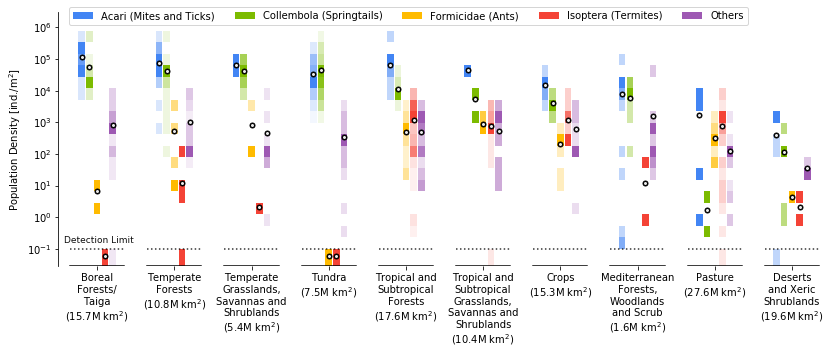

In [21]:
r = soil_site_data.reset_index()

conv = False #am I converting to mass? 
    # convert to mass
if conv == True:
    for ii in range(len(r)):
        r.loc[ii,'numerical value'] = r.loc[ii,'numerical value']* soil_ratio.loc[r.loc[ii,'aggregated taxon'],r.loc[ii,'aggregated biome']]

#Sort according to biomes total mean biomass, in a descending order
sorter = soil_biome_means.reset_index().groupby('aggregated biome').sum().sort_values(by='Mean',ascending=False).index
sorterIndex = dict(zip(sorter, range(len(sorter))))
r['sorting_biomes'] = r['aggregated biome'].map(sorterIndex)
r.sort_values(['sorting_biomes'],ascending = True, inplace = True)
r.drop('sorting_biomes', 1, inplace = True)        
    
original_biomes = r['aggregated biome'].unique()
transdict = {'Boreal Forests/Taiga': 'Boreal\nForests/\nTaiga\n(15.7M km$^2$)',
             'Crops':'Crops\n(15.3M km$^2$)',
             'Deserts and Xeric Shrublands':'Deserts\nand Xeric\nShrublands\n(19.6M km$^2$)',
             'Mediterranean Forests, Woodlands and Scrub':'Mediterranean\nForests,\nWoodlands\nand Scrub\n(1.6M km$^2$)',
             'Pasture':'Pasture\n(27.6M km$^2$)',
           'Temperate Forests':'Temperate\nForests\n(10.8M km$^2$)',
           'Temperate Grasslands, Savannas and Shrublands':'Temperate\nGrasslands,\nSavannas and\nShrublands\n(5.4M km$^2$)',
           'Tropical and Subtropical Forests':'Tropical and\nSubtropical\nForests\n(17.6M km$^2$)',
           'Tropical and Subtropical Grasslands, Savannas and Shrublands':'Tropical and\nSubtropical\nGrasslands,\nSavannas and\nShrublands\n(10.4M km$^2$)',
           'Tundra':'Tundra\n(7.5M km$^2$)'
            }

print_biomes = [transdict[biome] for biome in original_biomes]

r4 = r.replace(to_replace=original_biomes,value=print_biomes)

r4 = r4.loc[r4['numerical value']>=0] ###
bins = np.logspace(-1,np.log10(r4['numerical value'].max()),20)
bins = np.insert(bins,0,-0.1) #add the point -0.1 to the beginning of the bins array
#bins = np.logspace(r4['numerical value'].min(),r4['numerical value'].max(),20)   
t = r4.groupby(['aggregated biome','aggregated taxon'])['numerical value'].apply(lambda x: pd.cut(x,bins=bins).value_counts()/len(x)).reset_index()
y = t.groupby(['aggregated biome','aggregated taxon'])['numerical value'].apply(np.max).reset_index()
t3 = t.merge(y,left_on=['aggregated biome','aggregated taxon'],right_on=['aggregated biome','aggregated taxon'])
t3['val'] = t3['numerical value_x']/t3['numerical value_y']


#Isoptra = Isoptera_data.replace(to_replace=original_biomes,value=print_biomes)


fig,ax=plt.subplots(figsize=[12,5]) #[11,4])

fine_loc = pd.Series([-0.4,-0.2,0,0.2,0.4],index=['Acari','Collembola','Formicidae','Isoptera','Other'])
col_arr = ['#4285F4','#7CBB00','#FFBB00','#f44336','#9e59b3']

def print_data(x):
    col_map = pd.Series(col_arr,index=['Acari','Collembola','Formicidae','Isoptera','Other'])
    fine_loc = pd.Series([-0.4,-0.2,0,0.2,0.4],index=['Acari','Collembola','Formicidae','Isoptera','Other'])
    col = col_map.loc[x['aggregated taxon'].values[0]]
    locs = pd.Series(range(0,2*len(r4['aggregated biome'].unique()),2),index=r4['aggregated biome'].unique())
    xloc = locs.loc[x['aggregated biome'].values[0]] + fine_loc.loc[x['aggregated taxon'].values[0]]
    if x['val'].values[0] == 1:
        lab = x['aggregated taxon'].values[0]
    else:
        lab=None
    plt.bar(x=xloc,
            height=x['level_2'].values[0].right-x['level_2'].values[0].left,
            width=0.17,
            bottom=x['level_2'].values[0].left,
            log=True,color=col,alpha=x['val'].values[0],
            label=lab,
            zorder=1
           )
    ax.set_yscale('symlog',linthreshy=0.1)
    
    
def print_mean_median(x):
    locs = pd.Series(range(0,2*len(r4['aggregated biome'].unique()),2),index=r4['aggregated biome'].unique())
    xloc = locs.loc[x['aggregated biome'].values[0]] + fine_loc.loc[x['aggregated taxon'].values[0]]
    Mean = x['numerical value'].mean()
    SEM = x['numerical value'].sem()
    Y = (Mean, Mean - SEM , Mean + SEM)
    plt.scatter(x=xloc,y=Y[0],marker='.',c='k',s=40,zorder=3)
    plt.scatter(x=xloc,y=Y[1],marker='_',c='k',s=40,zorder=3)
    plt.scatter(x=xloc,y=Y[2],marker='_',c='k',s=40,zorder=3)
    
    
def print_mean_log(x):
    locs = pd.Series(range(0,2*len(r4['aggregated biome'].unique()),2),index=r4['aggregated biome'].unique())
    xloc = locs.loc[x['aggregated biome'].values[0]] + fine_loc.loc[x['aggregated taxon'].values[0]]
    Y = LogMean(x['numerical value'],kk = 1,scale = 1e6)
    plt.scatter(x=xloc,y= Y[0],marker='o',c='#941751', alpha=0.5,s=40,zorder=4)
    plt.scatter(x=xloc,y= Y[1],marker='2',c='#941751', alpha=0.5,s=40,zorder=4)
    plt.scatter(x=xloc,y= Y[2],marker='1',c='#941751', alpha=0.5,s=40,zorder=4)
    plt.scatter(x=xloc,y= (Y[0]+x['numerical value'].mean())/2,marker='4',c='m', alpha=1,s=40,zorder=4)
    

def print_combined_mean(x):
    locs = pd.Series(range(0,2*len(r4['aggregated biome'].unique()),2),index=r4['aggregated biome'].unique())
    xloc = locs.loc[x['aggregated biome'].values[0]] + fine_loc.loc[x['aggregated taxon'].values[0]]
    Y = calc_mean(x['numerical value'])+0.08
    plt.scatter(x=xloc,y= Y,marker='.' ,c='k', alpha=1,s=100,zorder=3)
    plt.scatter(x=xloc,y= Y,marker='.' ,c='#EBEBEB', alpha=1,s=15,zorder=3)    

def print_combined_errors(x):
    locs = pd.Series(range(0,2*len(r4['aggregated biome'].unique()),2),index=r4['aggregated biome'].unique())
    xloc = locs.loc[x['aggregated biome'].values[0]] + fine_loc.loc[x['aggregated taxon'].values[0]]
    Y1 = calc_min(x['numerical value'])
    Y2 = calc_max(x['numerical value'])
    plt.scatter(x=xloc,y=Y1 ,marker='_',c='k',s=40,zorder=3)
    plt.scatter(x=xloc,y=Y2 ,marker='_',c='k',s=40,zorder=3)
    
#Print fine average of Isoptera
def print_mean_Isoptera(x):
    fine_loc_Iso = 0.2;
    locs = pd.Series(range(0,2*len(r4['aggregated biome'].unique()),2),index=r4['aggregated biome'].unique())
    xloc = locs.loc[x['aggregated biome'].values[0]] + fine_loc_Iso
    plt.scatter(x=xloc,y=x['Mid estimate'],marker='*',c='k', alpha=1,s=40,zorder=4)
    plt.scatter(x=xloc,y=x['Mid estimate'],marker='*',c='#EBEBEB', alpha=1,s=15,zorder=4)
    plt.scatter(x=xloc,y=x['Low estimate'],marker='+',c='k', alpha=1,s=40,zorder=4)
    plt.scatter(x=xloc,y=x['High estimate'],marker='+',c='k', alpha=1,s=40,zorder=4)

    
    
    
#     if x['val'].values[0] >0:
#         plt.plot([xloc-0.17/2,xloc+0.17/2],[x['level_2'].values[0].right,x['level_2'].values[0].right],color='k',linewidth=0.7,alpha=1)
for i in range(0,2*len(r4['aggregated biome'].unique()),2):    
    plt.plot([i-0.7,i+0.7],[0.05,0.05],'k')   #plot lines for labels
#    plt.plot([i-0.7,i+0.7],[1.01e-2,1.01e-2],'k')   #plot lines for labels
    plt.plot([i-0.7,i+0.7],[1e-1,1e-1],'k:',alpha = 0.8)        #plot dotted lines for breaking points

ax = t3.groupby(['aggregated biome','aggregated taxon','level_2']).apply(print_data)
ax = plt.gca()
ax.set_xticks(range(0,2*len(r4['aggregated biome'].unique()),2))
ax.set_xticklabels(r4['aggregated biome'].unique())
ax.get_label()
if conv == False:
    ax.set_ylabel('Population Density [ind./m$^2$]')
    #plt.legend()
    ax.set_ylim([0.05,3e6])
    ax.set_xlim([-1,19])
    legend_without_duplicate_labels(ax,(0.007,0.93))
    sb.despine(top=True, bottom=True, right=True)
    ax.text(0.007, 0.12, 'Detection Limit', transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=None, color = 'k', alpha = 0.95)
else:
    ax.set_ylabel('Effective Biomass Density [mg/m$^2$]')
    ax.set_ylim([0.05,1.1e5])
    ax.set_xlim([-1,19])
    legend_without_duplicate_labels(ax,(0.007,0.97))
    sb.despine(top=True, bottom=True, right=True)
    ax.text(0.007, 0.125, 'Detection Limit', transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=None, color = 'k', alpha = 0.95)    

#r4.groupby(['aggregated biome','aggregated taxon']).apply(print_mean_median)##
#r4.groupby(['aggregated biome','aggregated taxon']).apply(print_mean_log)##
#Isoptra.groupby(['aggregated biome','aggregated taxon']).apply(print_mean_Isoptera)##
#r4.groupby(['aggregated biome','aggregated taxon']).apply(print_combined_errors)##
r4.groupby(['aggregated biome','aggregated taxon']).apply(print_combined_mean)##

plt.tight_layout()



# axins = inset_axes(ax,
#                    width="1.3%",  # width = 5% of parent_bbox width
#                    height="35%",  # height : 50%
#                    loc='lower left',
#                    bbox_to_anchor=(1.02, 0.05, 1, 1),
#                    bbox_transform=ax.transAxes,
#                    borderpad=0,
#                    )

# cmap = plt.get_cmap('Greys', 10)
# cbar = cm.ScalarMappable(cmap=cmap)
# cbar.set_array(np.array([0,1]))
# cb = fig.colorbar(cbar, cax=axins,shrink=0.4,ticks=[0,1],aspect=10)
# cb.ax.set_yticklabels(['least frequent','most frequent'])
# cb.outline.set_visible(False)


plt.savefig('results/fig_pop_dens.svg',dpi=300) ##
plt.savefig('results/fig_pop_dens.pdf',dpi=300) ##
plt.savefig('results/fig_pop_dens.png',dpi=600) ##






9. Calculate the total population in soils

In [ ]:
#soil_biome_Mean = soil_biome_means.Mean #take the combined mean per taxon and biome
soil_biome_Mean = soil_biome_means#.reset_index()
biome_area = pd.read_csv('data/aggregated biomes data.csv') # biomes area in units of m^2
biome_area1 = biome_area.groupby('aggregated biome 1')['area'].sum() #aggregate the biomes areas
soil_biome_Mean1 = soil_biome_Mean.merge(pd.DataFrame(biome_area1),left_on='aggregated biome',right_index=True) #add the total areas of the aggregated biomes to the means DF
soil_biome_Mean1.loc[:,'Total'] = (soil_biome_Mean1.loc[:,'Mean']*soil_biome_Mean1.loc[:,'area']).values #total population per biome, in units of mg. (use 1e18 to convert to Gt)
soil_biome_Mean1.loc[:,'Total_high'] = (soil_biome_Mean1.loc[:,'Max']*soil_biome_Mean1.loc[:,'area']).values #total population per biome, in units of mg. (use 1e18 to convert to Gt)
soil_biome_Mean1.loc[:,'Total_low'] = (soil_biome_Mean1.loc[:,'Min']*soil_biome_Mean1.loc[:,'area']).values #total population per biome, in units of mg. (use 1e18 to convert to Gt)

total_soil = soil_biome_Mean1.loc[:,['Total_high','Total','Total_low']].sum()

print('total high estimate is: ' + "{:.2e}".format(total_soil['Total_high']) + ' individuals in soils')
print('total mid estimate is: ' + "{:.2e}".format(total_soil['Total'] ) + ' individuals in soils')
print('total low estimate is: ' + "{:.2e}".format(total_soil['Total_low'])  + ' individuals in soils')


In [ ]:
soil_taxon_tot = soil_biome_Mean1.groupby('aggregated taxon')['Total_high','Total','Total_low'].sum()
print(soil_taxon_tot['Total_high']/soil_taxon_tot['Total'])
print(soil_taxon_tot['Total_low']/soil_taxon_tot['Total'])


In [ ]:
Labels=['Acari','Collembola','Formicidae','Isoptera','Other']

fig, (ax1,ax2,ax3) = plt.subplots(1, 3,figsize=[12,4])
fig.suptitle('Total soil population breakdown')

ax1.pie(((soil_biome_Mean1.groupby('aggregated taxon').Total.sum())/total_soil['Total']) , colors=col_arr, labels=Labels,autopct='%1.0f%%')
ax2.pie(((soil_biome_Mean1.groupby('aggregated taxon')['Total_low'].sum())/total_soil['Total_low']) , colors=col_arr, labels=Labels,autopct='%1.0f%%')
ax3.pie(((soil_biome_Mean1.groupby('aggregated taxon')['Total_high'].sum())/total_soil['Total_high']) , colors=col_arr, labels=Labels,autopct='%1.0f%%')

ax1.title.set_text('mid estimates')
ax2.title.set_text('low estimates')
ax3.title.set_text('high estimates')

plt.show()

plt.tight_layout()
#fig.savefig('results/fig2a_pop.svg', dpi=300)
#fig.savefig('results/fig2a_pop.pdf', dpi=300)
#(part1.groupby('aggregated taxon').Total.sum()/1e18).apply(lambda x: x.nominal_value)


In [ ]:
#calculate the total population, divided according to sub-phyla
sp_soil_site_taxa_mean = soil_data.groupby(['aggregated taxon','sub-phylum','aggregated biome','site','taxon'])['numerical value'].mean().reset_index() # mean per taxon and site
sp_soil_site_data = sp_soil_site_taxa_mean.groupby(['aggregated taxon','sub-phylum','aggregated biome','site'])['numerical value'].sum() # sum over all taxa in sub-phyla and site

sp_soil_biome_means = sp_soil_site_data.reset_index().pivot_table(index=['sub-phylum','aggregated taxon'],columns='aggregated biome',values='numerical value', aggfunc=calc_mean)
sp_soil_biome_means = sp_soil_biome_means.drop('Mixed')
# area = biome_area.set_index('aggregated biome 1').loc[sp_soil_biome_means.columns,'area']
## new addition
area = biome_area.set_index('aggregated biome 1').merge(sp_soil_biome_means.T,left_index=True,right_index=True)['area']
area = area.reset_index().groupby('index').sum()['area']
##
tot_sp = (sp_soil_biome_means*area).groupby('sub-phylum').apply(np.nansum).sum()

ax = ((sp_soil_biome_means*area).groupby('sub-phylum').apply(np.nansum)/tot_sp).plot.pie(colors=['#4db6ac','#bdbdbd','#795548','#607d8b'],autopct='%1.0f%%')
#ax.title.set_text('mid estimates')

#plt.savefig('results/fig2b_pop.svg', dpi=300)
#plt.savefig('results/fig2b_pop.pdf', dpi=300)
#((sp_soil_biome_means*area).groupby('sub-phylum').apply(np.nansum)/tot_sp)

In [ ]:
fig,ax = plt.subplots(1,2,figsize=[13.5,4],dpi=300)
ax = plt.subplot(1,2,1)
group_sum = (soil_biome_Mean1.groupby('aggregated taxon').Total.sum())
group_sum.index = ['Acari\n(Mites & Ticks)','Collembola\n(Springtails)','Formicidae\n(Ants)','Isoptera\n(Termites)','Other']
group_colors = pd.Series(col_arr,index = group_sum.index)
group_sum.sort_values(ascending=False,inplace=True)

group_sum.sort_values(ascending=False).plot.bar(width = 0.6,color=group_colors.loc[group_sum.index],rot=0,ax=ax,log=True)
ax.set_ylabel('Population [ind.]')


ax2 = plt.subplot(1,2,2)
subphyla_sum = ((sp_soil_biome_means*area).groupby('sub-phylum').apply(np.nansum))
subphyla_sum.index = ['Chelicerata','Crustacea','Hexapoda','Myriapoda']
subphyla_colors = pd.Series(['#4db6ac','#bdbdbd','#795548','#607d8b'],index = subphyla_sum.index)
subphyla_sum.sort_values(ascending=False,inplace=True)
subphyla_sum.plot.bar(width = 0.5,color=subphyla_colors.loc[subphyla_sum.index],ax=ax2,rot=0,log=True)


ax.set_ylim([1e15,6e18])
ax2.set_ylim([1e15,6e18])
#ax.set(yticks=np.arange(0,200,50))
#ax2.set(yticks=np.arange(0,200,50))


#ax.set_ylim([0,0.21])
#ax2.set_ylim([0,0.21])
#ax.set(yticks=np.arange(0,0.25,0.05))
#ax2.set(yticks=np.arange(0,0.25,0.05))
# ax.set_ylabel('Population')
# plt.savefig('results/fig2b_pop.svg', dpi=300)
#ax.text(-0.8,7e18,'A',fontdict={'size':20})
#ax2.text(-0.8,7e18,'B',fontdict={'size':20})
ax.text(0.95,0.9,'A',fontdict={'size':20},transform = ax.transAxes)
ax2.text(0.95,0.9,'B',fontdict={'size':20},transform = ax2.transAxes)
plt.tight_layout()

#plt.savefig('results/fig2_pop.svg', dpi=300)
#plt.savefig('results/fig2_pop.pdf', dpi=300)##

# plt.savefig('results/fig2b_pop.svg', dpi=300)
# ((sp_soil_biome_means*area).groupby('sub-phylum').apply(np.nansum)/tot_sp.nominal_value)


10. Calculate population of arthropods found on canopies, in a similar way

In [ ]:
canopy_site_taxa_mean = canopy_data.groupby(['aggregated biome','site','taxon'])['numerical value'].mean().reset_index() #mean per taxon per site
canopy_site_data = canopy_site_taxa_mean.groupby(['aggregated biome','site'])['numerical value'].sum() #sum over each site

canopy_biome_means = canopy_site_data.reset_index().groupby(['aggregated biome'])['numerical value'].agg([calc_mean,calc_min,calc_max,calc_mean_log,calc_mean_ar,calc_mean_ar_sem,'count'])
canopy_biome_means.rename(columns={'calc_mean': 'Mean', 'calc_min': 'Min', 'calc_max': 'Max', 'calc_mean_log': 'Mean_Log', 'calc_mean_ar': 'Mean_Ar','calc_mean_ar_sem': 'Sem_Ar', 'count': 'N'}, inplace=True)

#canopy_biome_means = canopy_site_data.reset_index().pivot_table(index='aggregated biome',values='numerical value', aggfunc=[calc_mean,'count']) #calculate the mean

#canopy_biome_means = canopy_biome_means.droplevel(axis=1,level=0)
#canopy_biome_means.columns = ['mean','N']

canopy_biome_means_print = canopy_biome_means.applymap(print_u)
#canopy_biome_means_print.to_csv('results/table_1canopy_pop.csv')#save
canopy_biome_means_print

In [ ]:
canopy_biome_Mean1 = canopy_biome_means.merge(pd.DataFrame(biome_area1),left_on='aggregated biome',right_index=True) #add the total areas of the aggregated biomes to the means DF

canopy_biome_Mean1.loc[:,'Total'] = (canopy_biome_Mean1.loc[:,'Mean']*canopy_biome_Mean1.loc[:,'area']).values #total population per biome, in units of mg. (use 1e18 to convert to Gt)
canopy_biome_Mean1.loc[:,'Total_high'] = (canopy_biome_Mean1.loc[:,'Max']*canopy_biome_Mean1.loc[:,'area']).values #total population per biome, in units of mg. (use 1e18 to convert to Gt)
canopy_biome_Mean1.loc[:,'Total_low'] = (canopy_biome_Mean1.loc[:,'Min']*canopy_biome_Mean1.loc[:,'area']).values #total population per biome, in units of mg. (use 1e18 to convert to Gt)

total_canopy = canopy_biome_Mean1.loc[:,['Total_high','Total','Total_low']].sum()

print('total high estimate is: ' + "{:.2e}".format(total_canopy['Total_high']) + ' individuals on canopy')
print('total mid estimate is: ' + "{:.2e}".format(total_canopy['Total'] ) + ' individuals on canopy')
print('total low estimate is: ' + "{:.2e}".format(total_canopy['Total_low'])  + ' individualspopulation on canopy')

#total_canopy

In [ ]:
x = canopy_data.groupby(['aggregated biome','aggregated taxon','site','taxon'])['numerical value'].mean().reset_index() #mean per taxon per site
X = x.groupby(['aggregated taxon','aggregated biome','site'])['numerical value'].sum()
x = X.reset_index().groupby(['aggregated taxon','aggregated biome'])['numerical value'].agg([calc_mean,calc_min,calc_max,calc_mean_log,calc_mean_ar,calc_mean_ar_sem,'count'])
x.rename(columns={'calc_mean': 'Mean', 'calc_min': 'Min', 'calc_max': 'Max', 'calc_mean_log': 'Mean_Log', 'calc_mean_ar': 'Mean_Ar','calc_mean_ar_sem': 'Sem_Ar', 'count': 'N'}, inplace=True)

x



11. Calculate population of arthropods found on surface (and not taken with the soil and litter above), in a similar way

In [ ]:
surface_site_taxa_mean = surface_data.groupby(['aggregated biome','site','taxon'])['numerical value'].mean().reset_index()
surface_site_data = surface_site_taxa_mean.groupby(['aggregated biome','site'])['numerical value'].sum()

surface_biome_means = surface_site_data.reset_index().groupby(['aggregated biome'])['numerical value'].agg([calc_mean,calc_min,calc_max,calc_mean_log,calc_mean_ar,calc_mean_ar_sem,'count'])
surface_biome_means.rename(columns={'calc_mean': 'Mean', 'calc_min': 'Min', 'calc_max': 'Max', 'calc_mean_log': 'Mean_Log', 'calc_mean_ar': 'Mean_Ar','calc_mean_ar_sem': 'Sem_Ar', 'count': 'N'}, inplace=True)

surface_biome_means_print = surface_biome_means.applymap(print_u)
#surface_biome_means_print.to_csv('results/table_1surface_pop.csv')#save
surface_biome_means_print

In [ ]:
surface_biome_Mean1 = surface_biome_means.merge(pd.DataFrame(biome_area1),left_on='aggregated biome',right_index=True) #add the total areas of the aggregated biomes to the means DF

surface_biome_Mean1.loc[:,'Total'] = (surface_biome_Mean1.loc[:,'Mean']*surface_biome_Mean1.loc[:,'area']).values #total population per biome, in units of mg. (use 1e18 to convert to Gt)
surface_biome_Mean1.loc[:,'Total_high'] = (surface_biome_Mean1.loc[:,'Max']*surface_biome_Mean1.loc[:,'area']).values #total population per biome, in units of mg. (use 1e18 to convert to Gt)
surface_biome_Mean1.loc[:,'Total_low'] = (surface_biome_Mean1.loc[:,'Min']*surface_biome_Mean1.loc[:,'area']).values #total population per biome, in units of mg. (use 1e18 to convert to Gt)

total_surface = surface_biome_Mean1.loc[:,['Total_high','Total','Total_low']].sum()

print('total high estimate is: ' + "{:.2e}".format(total_surface['Total_high']) + ' individuals on surface')
print('total mid estimate is: ' + "{:.2e}".format(total_surface['Total'] ) + ' individuals on surface')
print('total low estimate is: ' + "{:.2e}".format(total_surface['Total_low'])  + ' individuals on surface')

12. Calculate the overall total population, assuming places with no data has no individuals

In [ ]:
overall_population = total_surface+total_canopy+total_soil
overall_population


In [ ]:


(pd.DataFrame([total_soil.Total,total_canopy.Total,total_surface.Total],index=['Soil','Canopy','Aboveground'])/overall_population.Total).plot.pie(y=0)
(pd.DataFrame([total_soil.Total,total_canopy.Total,total_surface.Total],index=['Soil','Canopy','Aboveground'])/overall_population.Total)

13. Calculate and plot the total population per aggregated biome 

In [ ]:
soil_tot_biome = soil_biome_Mean1.loc[:,['Total_high','Total','Total_low']].groupby('aggregated biome').sum()
surface_tot_biome = surface_biome_Mean1.loc[:,['Total_high','Total','Total_low']].groupby('aggregated biome').sum()
canopy_tot_biome = canopy_biome_Mean1.loc[:,['Total_high','Total','Total_low']].groupby('aggregated biome').sum()

frames = [soil_tot_biome,surface_tot_biome,canopy_tot_biome]
biome_totals = pd.concat(frames, keys=["soil", "surface", "canopy"], names = ['env'])

#biome_totals.to_csv('results/table_biome_totals_pop.csv')#save


biome_totals['err_low'] = (biome_totals.loc[:,'Total']-biome_totals.loc[:,'Total_low'])
biome_totals['err_high'] = (biome_totals.loc[:,'Total_high']-biome_totals.loc[:,'Total'])
a = biome_totals.reset_index().pivot(index = 'aggregated biome' , columns = 'env', values='Total')
err_l = biome_totals.reset_index().pivot(index = 'aggregated biome' , columns = 'env', values='err_low' ) 
err_h = biome_totals.reset_index().pivot(index = 'aggregated biome' , columns = 'env', values= 'err_high')

err = []
for col in err_l:  # Iterate over bar groups (represented as columns)
    err.append([err_l[col].values, err_h[col].values])
    

fig = plt.subplots(figsize=[12,4])
ax = plt.subplot(1,2,1)
a.plot.bar(yerr=err ,width = 0.8, color=['#008F00','#945200', '#FFD479' ],ax=ax,logy=True,stacked=False,rot=90,legend=False)
ax.set_ylabel('Total Population')
ticklabels = ['Boreal Forest', 'Crops','Desert','Mediteranian', 'Pasture','Temp. Forest', 'Temp.\nGrassland', 'Trop. Forest','Trop.\nGrassland','Tundra']
ax.xaxis.set_ticklabels(ticklabels)
ax.xaxis.label.set_visible(False)
#ax.set_ylim([0,100])
#ax.legend(loc = [1.01,0.7])
#ax.ticks

ax = plt.subplot(1,2,2)
a.plot.bar(width = 0.8, color=['#008F00','#945200', '#FFD479' ],ax=ax,logy=False,stacked=True)
ax.set_ylabel('Total Population')
ax.xaxis.set_ticklabels(ticklabels)
ax.xaxis.label.set_visible(False)
#ax.set_ylim([0,100])
ax.legend(loc = [1.01,0.7])

plt.tight_layout()

#plt.savefig('results/fig_pop_biome_totsig_.svg', dpi=300)
#plt.savefig('results/fig_pop_biome_tots.pdf', dpi=300)##

In [ ]:
#soil_biome_means_print_full

biome_totals.loc['soil',].Total/biome_totals.loc['soil',].Total.sum()

In [ ]:
#population per m^2, global average:
pop_m2 = (soil_biome_Mean1.groupby('aggregated taxon').Total.sum()/biome_area1.sum())
print(pop_m2)
print(pop_m2.sum())
print('\n')
print(pop_m2/pop_m2.sum())

print(overall_population/biome_area1.sum())